In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

In [21]:
df = pd.read_csv('Social_Network_Ads.csv') 

# Dataset Inspection

In [22]:
print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Dataset Shape: (400, 5)
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None
            User ID         Age  EstimatedSalary   Purchased
count  4.000000e+02  400.000000       400.000000  400.000000
mean   1.569154e+07   37.655000     69742.500000    0.357500


# Check for missing values

In [23]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

Missing values per column:
 User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

Total missing values: 0


# Since there are no missing values, we can just split the dataset into features(X) and target(Y)

In [24]:
X = df[['Gender', 'Age', 'EstimatedSalary']]  # Features
y = df['Purchased']  # Target; it is binary

# Preprocess the data

# Inspect Unique values in categorical columns

In [25]:
print("\nUnique Values in Categorical Columns:")
categorical_cols = ['Gender']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Unique Values in Categorical Columns:
Gender: ['Male' 'Female']


# One hot encoding: 
## Encode categorical column 'gender' as Female == 0/1 and drop Male because if we keep it, it will create multi collinearity and it doesnot make sense too.

# Scaling Numerical features
## Since Age is 2 digit and salary is 3 digit so we need to standardize them.
## Standardization  of numerical features to have a mean of 0 and standard deviation of 1 ensures all features contribute equally to the model without dominance by high-magnitude variables.

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'EstimatedSalary']),
        ('cat', OneHotEncoder(drop='first'), ['Gender'])  
    ])

# Transform entire feature set and save to original DataFrame

In [27]:
preprocessor.fit(X)
feature_names = ['Age_scaled', 'EstimatedSalary_scaled', 'Gender_Male']
X_transformed = preprocessor.transform(X)
df[feature_names] = pd.DataFrame(X_transformed, columns=feature_names)

# Verify new dataset

In [28]:
print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Dataset Shape: (400, 8)
    User ID  Gender  Age  EstimatedSalary  Purchased  Age_scaled  \
0  15624510    Male   19            19000          0   -1.781797   
1  15810944    Male   35            20000          0   -0.253587   
2  15668575  Female   26            43000          0   -1.113206   
3  15603246  Female   27            57000          0   -1.017692   
4  15804002    Male   19            76000          0   -1.781797   

   EstimatedSalary_scaled  Gender_Male  
0               -1.490046          1.0  
1               -1.460681          1.0  
2               -0.785290          0.0  
3               -0.374182          0.0  
4                0.183751          1.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 400 non-null    int64  
 1   Gender                  400 non-null    object 
 2   

# Split data into train/test (80/20) using the transformed columns since we need it only

In [29]:
X_transformed = df[['Age_scaled', 'EstimatedSalary_scaled', 'Gender_Male']]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Train the model

In [30]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


# Predict on test set

In [31]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 Purchased  = 1 predict

# Save test set results to CSV

In [32]:
results_df = pd.DataFrame({
    'Age_scaled': X_test['Age_scaled'],
    'EstimatedSalary_scaled': X_test['EstimatedSalary_scaled'],
    'Gender_Male': X_test['Gender_Male'],
    'Purchased': y_test,
    'Predicted': y_pred,
    'Probability_Purchased': y_pred_proba
})
results_df.to_csv('test_predictions.csv', index=False)
print("\nTest set predictions saved to 'test_predictions.csv'")
print("\nPreview of Test Set Results:")
print(results_df.head())



Test set predictions saved to 'test_predictions.csv'

Preview of Test Set Results:
     Age_scaled  EstimatedSalary_scaled  Gender_Male  Purchased  Predicted  \
209    0.797057               -1.401952          0.0          0          0   
280    2.038728                0.536129          0.0          1          1   
33    -0.922179               -0.755925          0.0          0          0   
210    0.988083                0.771048          0.0          1          1   
93    -0.826666               -1.225763          0.0          0          0   

     Probability_Purchased  
209               0.250859  
280               0.972759  
33                0.021294  
210               0.848850  
93                0.015333  


# Evaluation Metrics

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'\nEvaluation Metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Evaluation Metrics:
Accuracy: 0.89
Precision: 0.91
Recall: 0.75
F1-Score: 0.82
ROC-AUC: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        52
           1       0.91      0.75      0.82        28

    accuracy                           0.89        80
   macro avg       0.90      0.86      0.87        80
weighted avg       0.89      0.89      0.88        80

Confusion Matrix:
 [[50  2]
 [ 7 21]]


# Confusion matrix

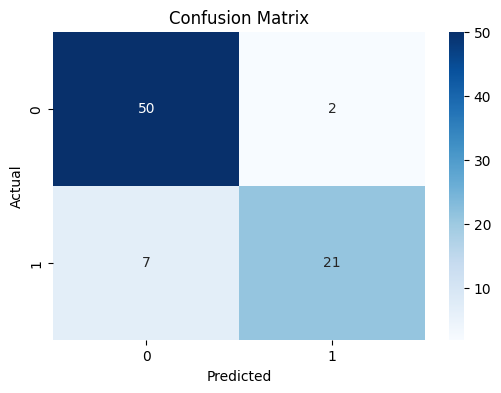

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Visualization of ROC Curve

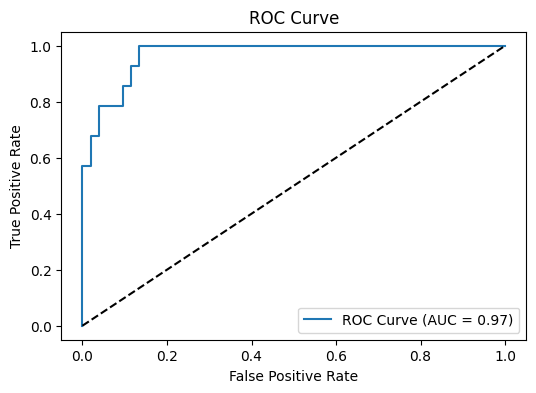

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Feature Coefficients

In [36]:
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_[0]})
print('\nModel Coefficients:\n', coef_df)


Model Coefficients:
                   Feature  Coefficient
0              Age_scaled     2.011251
1  EstimatedSalary_scaled     1.120776
2             Gender_Male     0.198391
